# 미니 프로젝트: 차량 파손 여부 분류 자동화 모델 개발
> 차량 공유업체의 차량 파손 여부 확인 업무를 자동화할 수 있는 분류 모델 개발

<img src="https://story.s-oil.com/wp-content/uploads/2021/09/%EC%B0%A8%EB%B0%95%EC%82%AC_02.jpg" height="400px">


# 단계 1. 데이터 전처리

## 1.환경설정

In [2]:
# keras 버전 Up
!pip install keras --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.2.0 which is incompatible.


In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### (1) 라이브러리 불러오기

In [4]:
# 데이터 전처리
import gdown, zipfile
import os, glob, shutil
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

### (2) 데이터 불러오기

- 드라이브 연결

In [5]:
from google.colab import drive

# 구글 드라이브 마운트
drive.mount('/content/drive')

Mounted at /content/drive


- 데이터 압축 해제

In [6]:
def dataset_extract(file_name) :

    # zip 파일에서 파일 추출하기
    with zipfile.ZipFile(file_name, 'r') as zip_ref :

        # zip 폴더 내 모든 파일 가져오기
        file_list = zip_ref.namelist()

        # 폴더가 이미 존재하는 경우
        if os.path.exists(f'/content/Car_Images/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        # 폴더가 존재 하지 않은 경우
        else :
            # zip 폴더 내 파일 추출하기 (tqdm -> 과정 시각화)
            for f in tqdm(file_list, desc='Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'/content/Car_Images/')

In [7]:
dataset_extract('/content/drive/MyDrive/AIVLE/시각지능/mini_project/Car_Images.zip')

Extracting: 100%|██████████| 607/607 [00:21<00:00, 28.15files/s]


- 데이터 불러오기

In [8]:
# 경로
path = '/content/Car_Images/'

# 이미지 데이터 불러오기
normal_files = glob.glob(path+"normal/*")
abnormal_files = glob.glob(path+"abnormal/*")

- 이미지 데이터 개수 확인하기

In [9]:
# 각 Class 데이터 수 확인
print( f'정상 차량 이미지 수 : {len(normal_files)}' )
print( f'파손 차량 이미지 수 : {len(abnormal_files)}' )

정상 차량 이미지 수 : 302
파손 차량 이미지 수 : 303


- 이미지 시각화

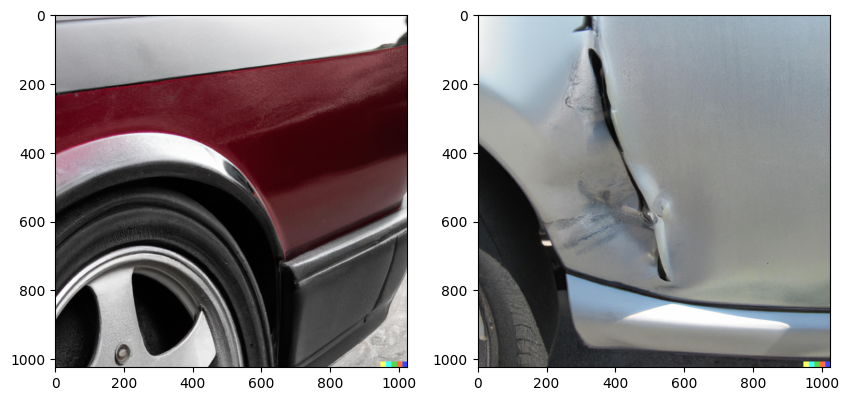


 정산 차량 이미지 차원 : (1024, 1024, 3)

 파손 차량 이미지 차원 : (1024, 1024, 3)


In [10]:
import random

# 랜덤한 이미지 Index
id = random.randint(0, len(normal_files) - 1)

# 이미지 시각화
plt.figure(figsize=(10,5))

# 정상 차량
plt.subplot(1,2,1)
normal_img = plt.imread(normal_files[id])   # plt.imread(img)     : Img 배열로 불러오기
plt.imshow(normal_img)                      # plt.imshow(img_arr) : 배열 이미지로 시각화

# 파손 차량
plt.subplot(1,2,2)
abnormal_img = plt.imread(abnormal_files[id])
plt.imshow(abnormal_img)
plt.show()

print('\n 정산 차량 이미지 차원 :', normal_img.shape)
print('\n 파손 차량 이미지 차원 :', abnormal_img.shape)

## 2.데이터 전처리
* 모델링을 위한 데이터 구조 생성
    * X : 이미지를 array로 변환
    * Y : normal -> 0, abnormal -> 1 Encoding

### (1) X : image to array
- 이미지 -> 배열

In [11]:
from keras.preprocessing import image

In [12]:
# 정상 차량 이미지 폴더
normal_files = glob.glob(path+"normal/*")

normal_images = []

# 정상 차량 이미지 배열로 불러오기
for file_name in normal_files :
    img = image.load_img(file_name, target_size=(256,256) )   # image.load_img()     : 이미지 불러오기
    img = image.img_to_array(img)                             # image.img_to_array() : 이미지 -> 배열
    normal_images.append(img)

# 각 이미지 배열 -> Numpy 형태로 변환
normal_images = np.array(normal_images)
normal_images.shape

(302, 256, 256, 3)

In [13]:
# 파손 차량 이미지 폴더
abnormal_files = glob.glob(path+"abnormal/*")

abnormal_images = []

# 파손 차량 이미지 배열로 불러오기
for file_name in abnormal_files :
    img = image.load_img(file_name, target_size=(256,256) )   # image.load_img()     : 이미지 불러오기
    img = image.img_to_array(img)                             # image.img_to_array() : 이미지 -> 배열
    abnormal_images.append(img)

abnormal_images = np.array(abnormal_images)
abnormal_images.shape

(303, 256, 256, 3)

### (2) Y : Labels 생성
- Encoding : normal -> 0, abnormal -> 1

In [14]:
# Y Class 만들기
normal_len = normal_images.shape[0]        # 302
abnormal_len = abnormal_images.shape[0]    # 303

normal_y = np.zeros((302,))
abnormal_y = np.ones((303,))

### (3) 데이터 통합
- 정상 차량 + 파손 차량 데이터 결합 (Image, Labels)


In [15]:
images = np.concatenate((normal_images, abnormal_images), axis = 0)
labels = np.concatenate((normal_y, abnormal_y), axis = 0)

In [16]:
images.shape, labels.shape

((605, 256, 256, 3), (605,))

### (4) 데이터셋 분리
- **세부요구사항**
    - 데이터 스플릿의 비율 (1) : train set, test set = 90%, 10%으로 설정하세요.
    - 데이터 스플릿의 비율 (2) : train set, valid set = 90%, 10%으로 설정하세요.

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.1, random_state=1, stratify=labels)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.1, random_state=1, stratify=y_train)

In [18]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(489, 256, 256, 3)
(55, 256, 256, 3)
(61, 256, 256, 3)


### (5) 전처리 데이터 저장

In [23]:
# 저장
# 전처리된 데이터를 저장할 파일 경로 설정
file_path = '/content/drive/MyDrive/AIVLE/preprocessed_data.npz'

# 전처리된 데이터를 NumPy 배열로 변환
X_train_np = np.array(X_train)
X_valid_np = np.array(X_valid)
X_test_np = np.array(X_test)
y_train_np = np.array(y_train)
y_valid_np = np.array(y_valid)
y_test_np = np.array(y_test)

# NumPy 배열을 파일로 저장
np.savez(file_path, X_train=X_train_np, X_valid=X_valid_np, X_test=X_test_np, y_train=y_train_np, y_valid=y_valid_np, y_test=y_test_np)